In [1]:
import os
os.chdir('../ssl_neuron/')

In [2]:
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from allensdk.core.cell_types_cache import CellTypesCache

In [3]:
from ssl_neuron.datasets import AllenDataset

/home/fpei2/miniconda3/envs/bmed7610/lib/python3.8/site-packages/tqdm-4.64.1-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
config = json.load(open('./ssl_neuron/configs/config.json'))
config['data']['n_nodes'] = 1000

In [5]:
ctc = CellTypesCache(manifest_file='./ssl_neuron/data/cell_types/manifest.json')

In [6]:
cells = ctc.get_cells()

ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)

morphology_features = ctc.get_morphology_features()
morph_df = pd.DataFrame(morphology_features)

In [7]:
dset = AllenDataset(config, mode='all')

430it [00:07, 54.13it/s] 


In [8]:
latents = np.load('../analysis/latents.npy')

In [10]:
ef_df = ef_df.set_index('specimen_id').loc[dset.cell_ids]

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVR

from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [ ]:
def fit_eval_decoder(input_features, target_df, skip_cols=[], to_str_cols=[]):
    np.random.seed(0)
    score_dict = {}
    pred_truth_dict = {}
    for col in target_df.columns:
        if col in skip_cols:
            continue
        elif col in to_str_cols:
            targets = np.array([str(item) for item in target_df[col]], dtype='object')
        else:
            targets = target_df[col].to_numpy()
        targets = ef_df[col].to_numpy()
        if targets.dtype == float or targets.dtype == int:
            gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-8, 0, 5)})
            # gscv = GridSearchCV(SVR(), {'C': np.logspace(-8, 0, 5)})
            mask = np.isnan(targets)
            if np.sum(~mask) == 0:
                print(f'skipping col {col} because there is no valid data')
                continue
            inputs = input_features[~mask]
            targets = targets[~mask]
            targets = StandardScaler().fit_transform(targets[:, None]).flatten()
        elif targets.dtype == bool:
            if len(np.unique(targets)) < 2:
                print(f'skipping col {col} because there is only one value')
                continue
            inputs = input_features
            targets = targets.astype(int)
            gscv = GridSearchCV(LogisticRegression(), {})
        elif targets.dtype == str:
            if len(np.unique(targets)) < 2:
                print(f'skipping col {col} because there is only one value')
                continue
            inputs = input_features
            targets = LabelEncoder().fit_transform(targets)
            gscv = GridSearchCV(LogisticRegression(), {})
        else:
            print(f'skipping col {col} due to unsupported dtype {targets.dtype}')
            continue
        perm = np.random.permutation(inputs.shape[0])
        gscv.fit(inputs[perm], targets[perm])
        score_dict[col] = gscv.best_score_
        # escore_dict[col] = gscv.score(inputs, targets)
        pred_truth_dict[col] = (gscv.predict(inputs), targets)

In [12]:
ef_df

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
specimen_id,,,,,,,,,,,,,,,,,,,,,
313862167,0.003120,30.758833,-109.973114,0.413095,1.155535,6.304327,1.026000,-58.156250,-58.510418,-67.010419,...,6.308035,1.211210,-58.687500,-59.062503,-81.114586,1.663913,1.594071,1.715118,-100.531250,-79.635635
313862373,NaN,NaN,18.666874,0.054545,1.028160,22.146930,1.024093,-62.468754,-57.015625,-63.140626,...,22.147105,1.380108,-62.593750,-57.140625,-78.156250,1.285196,0.948812,1.380051,-84.843758,-76.893822
321708130,0.000337,11.155114,NaN,1.042857,1.030645,14.122552,1.024554,-60.656250,-54.687502,-63.052084,...,14.122670,1.758959,-60.718754,-54.859375,-83.078125,1.545615,1.093126,1.580791,-90.187508,-81.008278
323452196,0.002758,12.570641,-3.823750,0.542210,1.033565,9.869315,1.024293,-65.812500,-61.734377,-67.671879,...,9.869345,1.046291,-65.875000,-61.828125,-73.710939,1.263677,1.095992,1.348704,-87.312508,-72.135956
323475862,0.262938,160.955000,9.615625,0.112884,1.217590,3.152270,1.024940,-52.843750,-55.635419,-60.070314,...,3.152365,1.658825,-52.906254,-55.718750,-69.117189,2.144345,2.108829,1.874775,-99.656258,-70.045471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602822298,NaN,NaN,-45.990000,0.055945,1.106360,7.670160,1.025147,-50.687504,-48.875004,-55.489586,...,7.683360,1.882853,-56.468750,-53.531250,-77.687505,2.691759,2.449154,2.842388,-88.656258,-76.960556
603402458,0.093247,93.134000,-17.667499,0.185351,1.208240,3.569680,1.025527,-45.000000,-47.197919,-47.348960,...,3.614247,1.654677,-54.968754,-55.156251,-72.848960,4.490296,4.842767,4.174782,-93.750008,-71.946854
603423462,0.032462,78.901818,-23.422500,0.162066,1.210940,5.391590,1.025205,-43.906254,-46.453125,-47.875003,...,5.438590,1.784505,-54.250000,-53.531252,-80.445314,4.853807,4.245228,3.706315,-94.562508,-79.690643


In [13]:
# ef_df.columns

In [14]:
pc = PCA(n_components=2).fit_transform(latents)
z = TSNE(n_components=2, perplexity=30).fit_transform(latents)

In [145]:
udrls = ef_df['upstroke_downstroke_ratio_long_square'].to_numpy()

In [154]:
np.log(udrls)[:10]

array([0.50917218, 0.25091128, 0.4354219 , 0.23402598, 0.76283398,
       0.56767194, 0.42251957, 1.0967369 , 0.27613855, 0.13758599])

In [167]:
perm = np.random.permutation(430)
gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(0, 6, 7)}, cv=5)
gscv.fit(latents[perm], scaled_vrest[perm])
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001089,0.000225,0.000466,0.000079,1.0,{'alpha': 1.0},0.126811,0.081065,0.015437,-0.081457,0.198554,0.068082,0.095681,3
1,0.000938,0.000060,0.000402,0.000013,10.0,{'alpha': 10.0},0.124269,0.071622,0.055907,-0.065783,0.194735,0.076150,0.085969,1
2,0.000858,0.000026,0.000419,0.000047,100.0,{'alpha': 100.0},0.110877,0.072596,0.092172,-0.049397,0.153998,0.076049,0.068261,2
3,0.000899,0.000115,0.000391,0.000012,1000.0,{'alpha': 1000.0},0.060862,0.042513,0.062412,-0.021338,0.063556,0.041601,0.032399,4
4,0.000838,0.000022,0.000394,0.000014,10000.0,{'alpha': 10000.0},0.007443,0.000816,0.011824,-0.025370,-0.006035,-0.002265,0.013041,5
5,0.000874,0.000032,0.000400,0.000013,100000.0,{'alpha': 100000.0},-0.003593,-0.007282,0.001263,-0.026906,-0.019117,-0.011127,0.010372,6
6,0.000859,0.000037,0.000400,0.000034,1000000.0,{'alpha': 1000000.0},-0.004860,-0.008203,0.000052,-0.027107,-0.020592,-0.012142,0.010125,7


0.3855766691315752


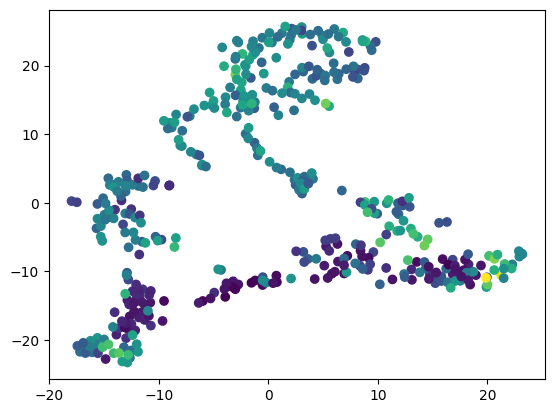

In [135]:
feature = 'upstroke_downstroke_ratio_long_square'
data = z
colorscale = (ef_df[feature] - ef_df[feature].min()) / (ef_df[feature].max() - ef_df[feature].min())
plt.scatter(data[:, 0], data[:, 1], c=colorscale)

In [172]:
np.random.seed(0)
escore_dict = {}
epred_truth_dict = {}
for col in ef_df.columns:
    if col in ['id', 'rheobase_sweep_id', 'rheobase_sweep_number']:
        continue
    targets = ef_df[col].to_numpy()
    if targets.dtype == float or targets.dtype == int:
        gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-8, 0, 5)})
        # gscv = GridSearchCV(SVR(), {'C': np.logspace(-8, 0, 5)})
        mask = np.isnan(targets)
        if np.sum(~mask) == 0:
            print(f'skipping col {col} because there is no valid data')
            continue
        inputs = latents[~mask]
        targets = targets[~mask]
        targets = StandardScaler().fit_transform(targets[:, None]).flatten()
    elif targets.dtype == bool:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        inputs = latents
        targets = targets.astype(int)
        gscv = GridSearchCV(LogisticRegression(), {})
    elif targets.dtype == str:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        inputs = latents
        targets = LabelEncoder().fit_transform(targets)
        gscv = GridSearchCV(LogisticRegression(), {})
    else:
        print(f'skipping col {col} due to unsupported dtype {targets.dtype}')
        continue
    perm = np.random.permutation(inputs.shape[0])
    gscv.fit(inputs[perm], targets[perm])
    escore_dict[col] = gscv.best_score_
    # escore_dict[col] = gscv.score(inputs, targets)
    epred_truth_dict[col] = (gscv.predict(inputs), targets)

skipping col has_burst because there is only one value
skipping col has_delay because there is only one value
skipping col has_pause because there is only one value


In [138]:
# plt.scatter(epred_truth_dict['vrest'][0], epred_truth_dict['vrest'][1])

In [139]:
# pearsonr(epred_truth_dict['vrest'][1], epred_truth_dict['vrest'][0])

In [173]:
max(list(escore_dict.values()))

0.42215716629130295

(-1.0, 1.0)

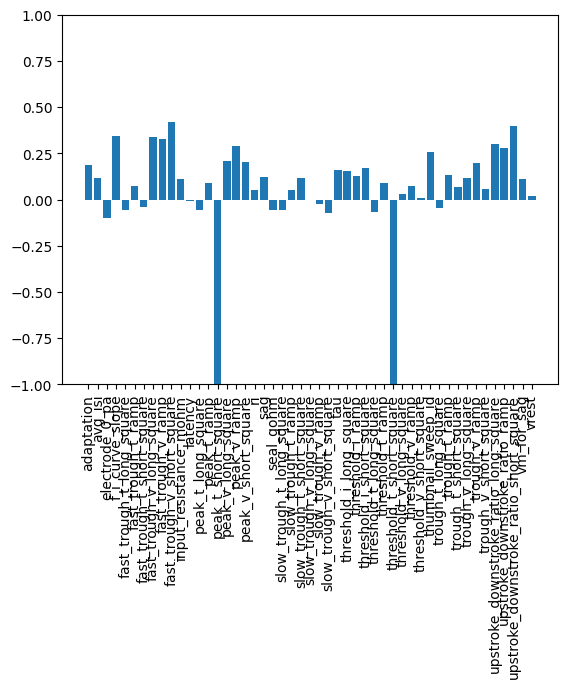

In [174]:
plt.bar(list(escore_dict.keys()), list(escore_dict.values()))
plt.xticks(rotation=90)
plt.ylim(-1, 1)

In [175]:
morph_df = morph_df[~morph_df.superseded].set_index('specimen_id').loc[dset.cell_ids]

In [176]:
morph_df

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id,max_branch_order,max_euclidean_distance,...,overall_width,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,superseded,tags,total_length,total_surface,total_volume
specimen_id,,,,,,,,,,,,,,,,,,,,,
313862167,62.163118,NaN,0.930364,0.464887,59.486486,0.858529,NaN,759904803,5.0,247.737791,...,327.150383,0.1144,0.1144,0.28,361.118559,False,3D Neuron Reconstruction morphology,2644.878298,3883.698604,512.836253
313862373,64.007529,NaN,0.888561,0.451611,58.833333,1.106200,NaN,657294860,5.0,251.498887,...,391.037985,0.1144,0.1144,0.28,856.908116,False,3D Neuron Reconstruction morphology,3140.951956,4447.856848,598.616420
321708130,84.566685,NaN,0.914024,0.317193,51.472222,0.914498,NaN,759896998,4.0,171.928465,...,276.926431,0.1144,0.1144,0.28,755.987172,False,3D Neuron Reconstruction morphology,2335.830949,2326.278506,188.047373
323452196,70.359932,NaN,0.931876,0.146125,40.250000,0.852783,NaN,513556739,3.0,197.455070,...,271.542295,0.1144,0.1144,0.28,82.736227,False,3D Neuron Reconstruction morphology,669.412456,308.880506,11.212091
323475862,73.299960,NaN,0.896349,0.267869,44.678571,0.845183,NaN,760196580,6.0,198.757384,...,291.582190,0.1144,0.1144,0.28,249.288252,False,3D Neuron Reconstruction morphology,1682.421703,1411.088094,106.669856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602822298,76.572001,NaN,0.844929,0.267292,55.403846,0.985393,NaN,675964893,10.0,556.383922,...,280.698521,0.1144,0.1144,0.28,112.514533,False,3D Neuron Reconstruction morphology,3459.468627,2906.003912,193.428072
603402458,73.364761,NaN,0.835574,0.579724,69.920000,0.958725,NaN,647860103,10.0,588.687224,...,421.042199,0.1144,0.1144,0.28,477.738333,False,3D Neuron Reconstruction morphology,3964.056968,7223.266317,1084.488626
603423462,89.351698,NaN,0.771530,0.756434,72.861111,1.000000,NaN,645065208,8.0,393.781324,...,400.249879,0.1144,0.1144,0.28,431.927313,False,3D Neuron Reconstruction morphology,3553.287028,8447.719998,1683.611965


In [177]:
np.random.seed(0)
mscore_dict = {}
mpred_truth_dict = {}
for col in morph_df.columns:
    if col in ['id', 'scale_factor_x', 'scale_factor_y', 'scale_factor_z']:
        continue
    targets = morph_df[col].to_numpy()
    if targets.dtype == float or targets.dtype == int:
        gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-8, 0, 5)})
        mask = np.isnan(targets)
        if np.sum(~mask) == 0:
            print(f'skipping col {col} because there is no valid data')
            continue
        inputs = latents[~mask]
        targets = targets[~mask]
        targets = StandardScaler().fit_transform(targets[:, None]).flatten()
    elif targets.dtype == bool:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        inputs = latents
        targets = targets.astype(int)
        gscv = GridSearchCV(LogisticRegression(), {})
    elif targets.dtype == str:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        inputs = latents
        targets = LabelEncoder().fit_transform(targets)
        gscv = GridSearchCV(LogisticRegression(), {})
    else:
        print(f'skipping col {col} due to unsupported dtype {targets.dtype}')
        continue
    perm = np.random.permutation(inputs.shape[0])
    gscv.fit(inputs[perm], targets[perm])
    mscore_dict[col] = gscv.best_score_
    # mscore_dict[col] = gscv.score(inputs, targets)
    mpred_truth_dict[col] = (gscv.predict(inputs), targets)

skipping col average_bifurcation_angle_remote because there is no valid data
skipping col hausdorff_dimension because there is no valid data
skipping col neuron_reconstruction_type due to unsupported dtype object
skipping col superseded because there is only one value
skipping col tags due to unsupported dtype object


(-1.0, 1.0)

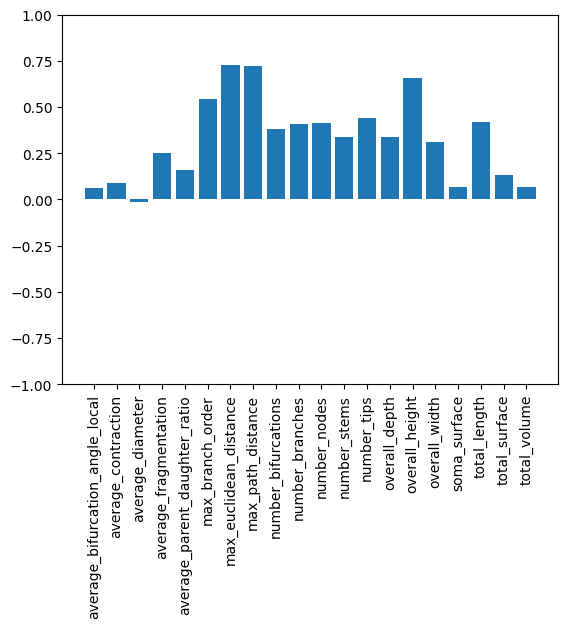

In [178]:
plt.bar(list(mscore_dict.keys()), list(mscore_dict.values()))
plt.xticks(rotation=90)
plt.ylim(-1, 1)

In [179]:
cell_df = pd.DataFrame(cells)
cell_df = cell_df.set_index('id').loc[dset.cell_ids]

In [180]:
cell_df

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,reconstruction_type,disease_state,donor_id,structure_hemisphere,normalized_depth
id,,,,,,,,,,,,,,,
313862167,positive,"[9279.53948496313, 1831.03502009105, 2151.2443...",Mus musculus,Sst-IRES-Cre;Ai14-167638.05.02.01,4,409,VISl,Sst-IRES-Cre,aspiny,NA,full,,313401544,right,0.340213
313862373,positive,"[9465.94223174317, 2210.36351644808, 2482.0829...",Mus musculus,Pvalb-IRES-Cre;Ai14-165171.03.01.01,6a,409,VISl,Pvalb-IRES-Cre,aspiny,NA,full,,312883105,left,0.841597
321708130,positive,"[8618.0, 1369.43242058597, 3174.10337433115]",Mus musculus,Pvalb-IRES-Cre;Ai14-172101.05.02.01,5,385,VISp,Pvalb-IRES-Cre,aspiny,NA,full,,320827555,right,0.757310
323452196,positive,"[9023.23570814057, 1886.97142008558, 2729.3802...",Mus musculus,Sst-IRES-Cre;Ai14-172534.04.02.01,6a,385,VISp,Sst-IRES-Cre,aspiny,NA,full,,320827615,right,0.923425
323475862,positive,"[8277.62472102039, 1252.35272652823, 8520.3510...",Mus musculus,Sst-IRES-Cre;Ai14-172534.06.01.01,5,385,VISp,Sst-IRES-Cre,aspiny,NA,full,,320827615,left,0.596803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602822298,positive,"[8821.21650323302, 1313.80147358458, 8740.2570...",Mus musculus,Tlx3-Cre_PL56;Ai14-333680.03.01.01,4,385,VISp,Tlx3-Cre_PL56,spiny,intact,dendrite-only,,601463654,left,0.573982
603402458,positive,"[9101.0254673891, 2295.22607710186, 9367.05470...",Mus musculus,Penk-IRES2-Cre-neo;Ai14-334280.04.01.01,6a,312782574,VISli,Penk-IRES2-Cre-neo,spiny,intact,dendrite-only,,602554250,left,0.773809
603423462,positive,"[9466.57733835882, 1680.01520329805, 3134.1395...",Mus musculus,Penk-IRES2-Cre-neo;Ai14-334280.02.02.01,6a,385,VISp,Penk-IRES2-Cre-neo,spiny,intact,dendrite-only,,602554250,right,0.811241


In [181]:
np.random.seed(0)
cscore_dict = {}
cpred_truth_dict = {}
for col in cell_df.columns:
    if col in ['name', 'species', 'donor_id']:
        continue
    elif col in ['structure_area_id']:
        targets = np.array([str(sa_id) for sa_id in cell_df[col]], dtype='object')
    else:
        targets = cell_df[col].to_numpy()
    if targets.dtype == float or targets.dtype == int:
        gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-8, 0, 4)})
        mask = np.isnan(targets)
        if np.sum(~mask) == 0:
            print(f'skipping col {col} because there is no valid data')
            continue
        inputs = latents[~mask]
        targets = targets[~mask]
        targets = StandardScaler().fit_transform(targets[:, None]).flatten()
    elif targets.dtype == bool:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        inputs = latents
        targets = targets.astype(int)
        gscv = GridSearchCV(LogisticRegression(), {})
    elif type(targets[0]) == str:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        inputs = latents
        targets = LabelEncoder().fit_transform(targets)
        gscv = GridSearchCV(LogisticRegression(), {})
    else:
        print(f'skipping col {col} due to unsupported dtype {targets.dtype}')
        continue
    perm = np.random.permutation(inputs.shape[0])
    gscv.fit(inputs[perm], targets[perm])
    # cscore_dict[col] = gscv.best_score_
    cscore_dict[col] = gscv.score(inputs, targets)
    cpred_truth_dict[col] = (gscv.predict(inputs), targets)

skipping col cell_soma_location due to unsupported dtype object


/home/fpei2/miniconda3/envs/bmed7610/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fpei2/miniconda3/envs/bmed7610/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

skipping col disease_state because there is only one value


(-1.0, 1.0)

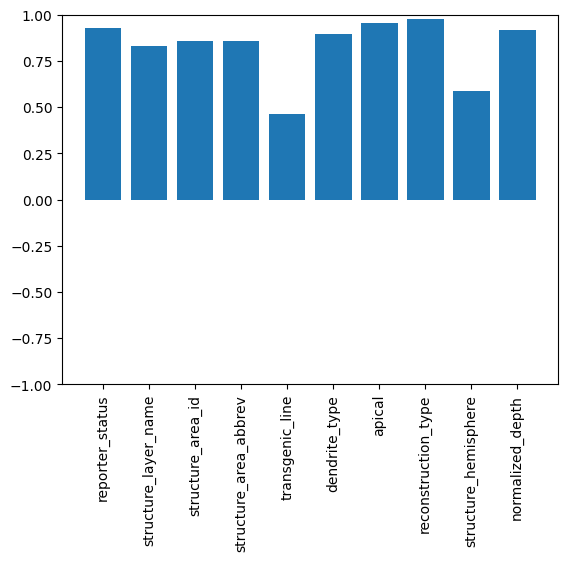

In [182]:
plt.bar(list(cscore_dict.keys()), list(cscore_dict.values()))
plt.xticks(rotation=90)
plt.ylim(-1, 1)

In [187]:
np.array(cell_df.cell_soma_location.tolist()).shape

(430, 3)

In [227]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

cell_type_input_columns = ['reporter_status', 'cell_soma_location',
       'structure_layer_name', 'structure_area_id', 'structure_area_abbrev',
       'transgenic_line', 'dendrite_type', 'apical', 'reconstruction_type',
       'disease_state', 'structure_hemisphere',
       'normalized_depth']
cell_features = []
for column in cell_type_input_columns:
    data = cell_df[column]
    if column == 'normalized_depth':
        data = data.to_numpy()
        data = StandardScaler().fit_transform(data[:, None])
    elif column == 'cell_soma_location':
        data = np.array(data.tolist())
        data = StandardScaler().fit_transform(data)
    else:
        if column == 'structure_area_id':
            data = np.array([str(sa_id) for sa_id in data], dtype='object')
        else:
            data = data.to_numpy()
        data = OneHotEncoder().fit_transform(data[:, None]).todense()
    cell_features.append(data)
cell_features = np.concatenate(cell_features, axis=1)

In [230]:
np.random.seed(0)
score_dict = {}
pred_truth_dict = {}
for col in ef_df.columns:
    if col in ['id', 'rheobase_sweep_id', 'rheobase_sweep_number']:
        continue
    targets = ef_df[col].to_numpy()
    if targets.dtype == float or targets.dtype == int:
        gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-8, 0, 5)})
        # gscv = GridSearchCV(SVR(), {'C': np.logspace(-8, 0, 5)})
        mask = np.isnan(targets)
        if np.sum(~mask) == 0:
            print(f'skipping col {col} because there is no valid data')
            continue
        inputs = cell_features[~mask]
        targets = targets[~mask]
        targets = StandardScaler().fit_transform(targets[:, None]).flatten()
    elif targets.dtype == bool:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        inputs = cell_features
        targets = targets.astype(int)
        gscv = GridSearchCV(LogisticRegression(), {})
    elif targets.dtype == str:
        if len(np.unique(targets)) < 2:
            print(f'skipping col {col} because there is only one value')
            continue
        inputs = cell_features
        targets = LabelEncoder().fit_transform(targets)
        gscv = GridSearchCV(LogisticRegression(), {})
    else:
        print(f'skipping col {col} due to unsupported dtype {targets.dtype}')
        continue
    perm = np.random.permutation(inputs.shape[0])
    gscv.fit(inputs[perm], targets[perm])
    score_dict[col] = gscv.best_score_
    # escore_dict[col] = gscv.score(inputs, targets)
    pred_truth_dict[col] = (gscv.predict(inputs), targets)

skipping col has_burst because there is only one value
skipping col has_delay because there is only one value
skipping col has_pause because there is only one value


(-1.0, 1.0)

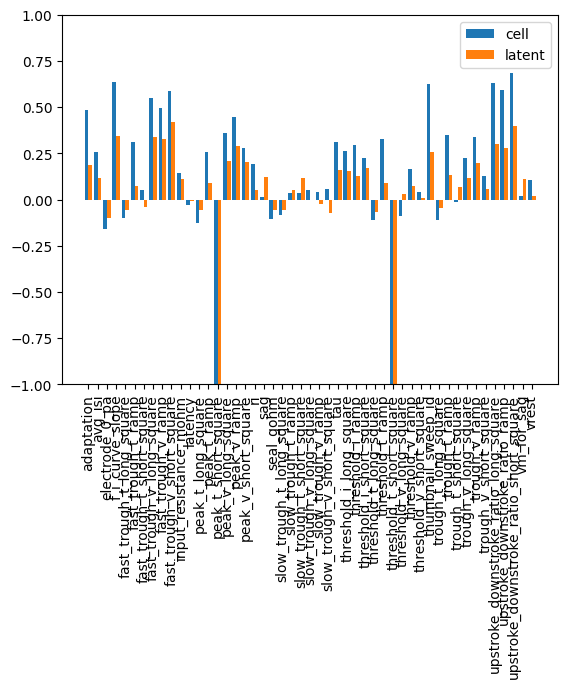

In [231]:
xlabels = list(score_dict.keys())
plt.bar(np.arange(len(xlabels)) - 0.2, list(score_dict.values()), 0.4, label='cell')
plt.bar(np.arange(len(xlabels)) + 0.2, list(escore_dict.values()), 0.4, label='latent')
plt.xticks(ticks=np.arange(len(xlabels)), labels=xlabels, rotation=90)
plt.legend()
plt.ylim(-1, 1)

In [70]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

In [101]:
# class MLP(nn.Module):
#     def __init__(self, input_size, layer_sizes, output_size, nonlinearity='relu', output_activation='none', dropout=0.1):
#         super(MLP, self).__init__()
#         self.layers = nn.ModuleList([
#             nn.Linear(
#                 (input_size if i == 0 else layer_sizes[i - 1]),
#                 (output_size if i == len(layer_sizes) else layer_sizes[i]),
#                 bias=True
#             ) for i in range(len(layer_sizes) + 1)
#         ])
#         if nonlinearity == 'sigmoid':
#             self.nonlinearity = torch.sigmoid
#         else:
#             self.nonlinearity = getattr(F, nonlinearity) if nonlinearity != 'none' else lambda x: x
#         self.output_activation = getattr(F, output_activation) if output_activation != 'none' else lambda x: x
#         self.dropout_rate = dropout
    
#     def forward(self, X):
#         for i, layer in enumerate(self.layers):
#             X = layer(X)
#             if i == len(self.layers) - 1:
#                 X = self.output_activation(X)
#             else:
#                 X = self.nonlinearity(X)
#                 X = F.dropout(X, p=self.dropout_rate, training=self.training)
#         return X

In [136]:
# targets = ef_df[['vrest']].to_numpy()
# targets = StandardScaler().fit_transform(targets)

# val_idx = np.random.choice(430, int(430 * 0.05), replace=False)
# train_idx = np.arange(430)[~np.isin(np.arange(430), val_idx)]

# train_data = latents[train_idx]
# train_output = targets[train_idx]

# val_data = latents[val_idx]
# val_output = targets[val_idx]

In [137]:
# train_data = torch.from_numpy(train_data).to(torch.float32)
# train_output = torch.from_numpy(train_output).to(torch.float32)

# val_data = torch.from_numpy(val_data).to(torch.float32)
# val_output = torch.from_numpy(val_output).to(torch.float32)

In [139]:
# model = MLP(32, [8], 1, 'relu', 'none', dropout=0.0)
# optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0e-1)

# for i in range(2000):
#     optimizer.zero_grad()
#     train_pred = model(train_data)
#     loss = F.mse_loss(train_pred, train_output)
#     loss.backward()
#     optimizer.step()

#     if (i % 50 == 0):
#         model.eval()
#         with torch.no_grad():
#             val_pred = model(val_data)
#             val_loss = F.mse_loss(val_pred, val_output)
#         val_r2 = r2_score(val_output.detach().cpu().numpy(), val_pred.detach().cpu().numpy())
#         train_r2 = r2_score(train_output.detach().cpu().numpy(), train_pred.detach().cpu().numpy())
#         total_r2 = r2_score(
#             np.concatenate([train_output.detach().cpu().numpy(), val_output.detach().cpu().numpy()], axis=0), 
#             np.concatenate([train_pred.detach().cpu().numpy(), val_pred.detach().cpu().numpy()], axis=0)
#         )
#         print(f'Iter {i:03d}: train loss = {loss.item():.3f}, val loss = {val_loss.item():.3f}, ' + 
#             f'total R2 = {total_r2:.3f}, train R2 = {train_r2:.3f}, val R2 = {val_r2:.3f}')
#         model.train()

Iter 000: train loss = 1.038, val loss = 0.846, total R2 = -0.029, train R2 = -0.032, val R2 = -0.172
Iter 050: train loss = 0.796, val loss = 0.691, total R2 = 0.209, train R2 = 0.209, val R2 = 0.043
Iter 100: train loss = 0.704, val loss = 0.821, total R2 = 0.290, train R2 = 0.300, val R2 = -0.137
Iter 150: train loss = 0.625, val loss = 0.950, total R2 = 0.359, train R2 = 0.378, val R2 = -0.316
Iter 200: train loss = 0.575, val loss = 1.132, total R2 = 0.398, train R2 = 0.428, val R2 = -0.568
Iter 250: train loss = 0.549, val loss = 1.167, total R2 = 0.421, train R2 = 0.455, val R2 = -0.616
Iter 300: train loss = 0.526, val loss = 1.184, total R2 = 0.442, train R2 = 0.477, val R2 = -0.640
Iter 350: train loss = 0.508, val loss = 1.215, total R2 = 0.458, train R2 = 0.495, val R2 = -0.682
Iter 400: train loss = 0.495, val loss = 1.258, total R2 = 0.468, train R2 = 0.508, val R2 = -0.742
Iter 450: train loss = 0.478, val loss = 1.268, total R2 = 0.483, train R2 = 0.525, val R2 = -0.757